In [1]:
from math import sqrt
from datetime import datetime
from numpy import concatenate
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, RepeatVector,TimeDistributed
from keras.layers import LSTM, Bidirectional, GRU, SimpleRNN
#from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk990_2_6ay.xlsx'
data = pd.read_excel(path, date_format=[0])
# İlk 5 Satır
data.head()

,DATE_TIME,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2022-06-01 00:00:00,119,1,60,162
1,2022-06-01 01:00:00,137,6,62,123
2,2022-06-01 02:00:00,132,6,62,68
3,2022-06-01 03:00:00,121,6,60,59
4,2022-06-01 04:00:00,128,5,56,88


In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M')
#İndex'e Alınması
data.index = data.DATE_TIME

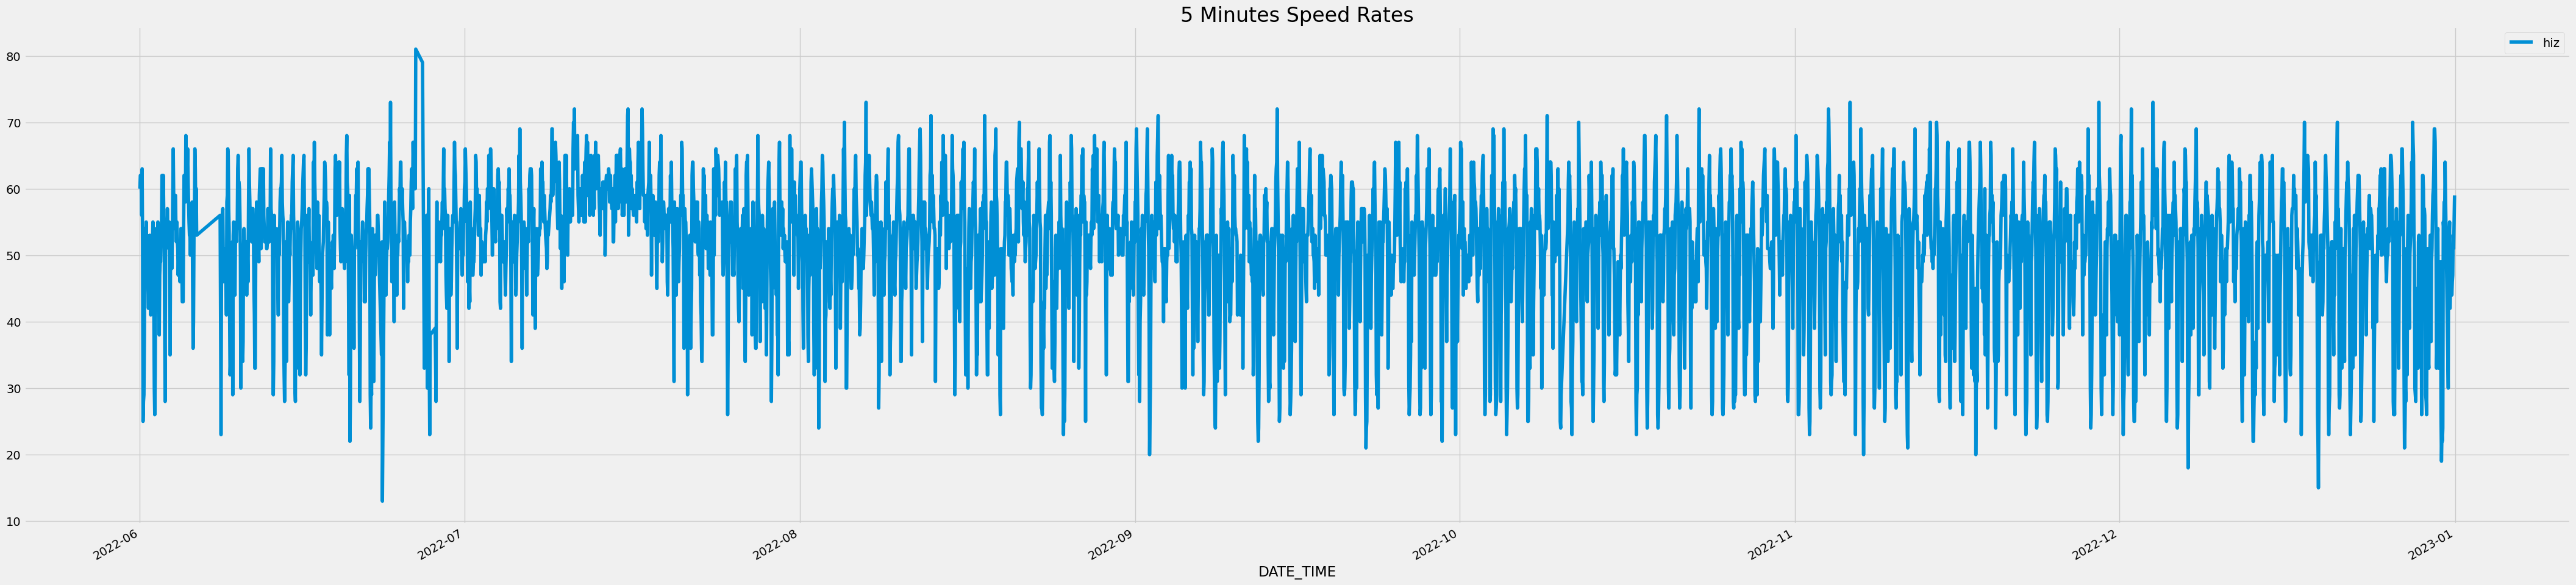

In [4]:
fig = plt.figure(figsize=(48,12))
data.AVERAGE_SPEED.plot(label='hiz')
plt.legend(loc='best')
plt.title('5 Minutes Speed Rates', fontsize=24)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Gün Sayıları (training set, test set): " + str((len(train), len(test))))
#dataset[train_size:len(dataset)]

Gün Sayıları (training set, test set): (2998, 2000)


In [8]:
def create_datasetMultiSteps(dataset, n_steps_out, window_size):
        dataX, dataY = [], []
        for i in range(int((len(dataset) - (window_size + n_steps_out) - 1))):
                a = dataset[i:(i + window_size), 0]
                b = dataset[(i + window_size):(i + window_size) + n_steps_out, 0]
                dataX.append(a)
                dataY.append(b)
        return np.array(dataX), np.array(dataY)

In [9]:
# Verisetlerimizi Oluşturalım
window_size = 6
n_steps_out = 3
train_X, train_Y = create_datasetMultiSteps(train,n_steps_out, window_size)
test_X, test_Y = create_datasetMultiSteps(test,n_steps_out, window_size)
print("Original training data shape:")
print(train_Y.shape)

Original training data shape:
(2988, 3)


In [10]:
# Yeni verisetinin şekline bakalım.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)
#train_Y = train_Y.reshape(-1,n_steps_out)
print(train_Y.shape)

New training data shape:
(2988, 1, 6)
(2988, 3)


In [11]:
model = Sequential()
model.add(SimpleRNN(128, input_shape=(1, window_size), return_sequences=True))
model.add(SimpleRNN(64, activation='relu', return_sequences=False))
model.add(RepeatVector(n_steps_out))
model.add(SimpleRNN(64, activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
model.fit(train_X, train_Y, epochs = 10, batch_size = 16, validation_data=(test_X, test_Y), verbose=0, shuffle=False)
    

In [12]:
y_test = test_Y.reshape(-1,n_steps_out)
x_test = test_X
y_train = train_Y.reshape(-1,n_steps_out)
x_train = train_X

In [13]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

63/63 [==============================] - 0s 2ms/step


In [14]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)
score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

ValueError: Found input variables with inconsistent numbers of samples: [2988, 8964]

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)
error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)

In [ ]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)
error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

In [ ]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

In [ ]:

plt.figure(figsize=(48, 16))
plt.plot(y_train_pred, label = "Train verisi Tahmin")
plt.plot(y_train, label = "Train verisi Gerçek")
plt.title('Train verisi Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
plt.show()

plt.figure(figsize=(48, 16))
plt.plot(y_test_pred, label = "Test verisi Tahmin")
plt.plot(y_test, label = "Test verisi Gerçek")
plt.title('Test verisi Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
plt.show()